<a href="https://colab.research.google.com/github/veeralipi22/Sentiment_Analysis_on_-Elon_musk_Tweets-Text-MIning/blob/main/Untitled6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import string
import warnings
import spacy
from tqdm.notebook import tqdm_notebook

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter



In [30]:
# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


In [31]:
# load the dataset
tweets=pd.read_csv('Elon_musk.csv',encoding='Latin-1')
tweets.drop(['Unnamed: 0'],inplace=True,axis=1)
tweets.rename({'Text':'Tweets'},axis=1,inplace=True)
tweets


,Tweets
0,@kunalb11 Im an alien
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
2,@joerogan @Spotify Great interview!
3,@gtera27 Doge is underestimated
4,@teslacn Congratulations Tesla China for amazi...
...,...
1994,"@flcnhvy True, it sounds so surreal, but the n..."
1995,@PPathole Make sure to read ur terms &amp; con...
1996,@TeslaGong @PPathole Samwise Gamgee
1997,@PPathole Altho Dumb and Dumber is <U+0001F525...


2. Data Exploration

In [35]:
#number of words
tweets['word_count'] = tweets['Tweets'].apply(lambda x: len(str(x).split(" ")))
tweets[['Tweets','word_count']].head()

,Tweets,word_count
0,@kunalb11 Im an alien,4
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,13
2,@joerogan @Spotify Great interview!,4
3,@gtera27 Doge is underestimated,4
4,@teslacn Congratulations Tesla China for amazi...,17


In [36]:
#Number of characters
tweets['char_count'] = tweets['Tweets'].str.len() ## this also includes spaces
tweets[['Tweets','char_count']].head()

,Tweets,char_count
0,@kunalb11 Im an alien,22
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,82
2,@joerogan @Spotify Great interview!,35
3,@gtera27 Doge is underestimated,31
4,@teslacn Congratulations Tesla China for amazi...,104


In [37]:
#average word length
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

tweets['avg_word'] = tweets['Tweets'].apply(lambda x: avg_word(x))
tweets[['Tweets','avg_word']].head()


,Tweets,avg_word
0,@kunalb11 Im an alien,4.750000
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,5.384615
2,@joerogan @Spotify Great interview!,8.000000
3,@gtera27 Doge is underestimated,7.000000
4,@teslacn Congratulations Tesla China for amazi...,5.176471


In [38]:
#number of stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')

tweets['stopwords'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x in stop]))
tweets[['Tweets','stopwords']].head()


,Tweets,stopwords
0,@kunalb11 Im an alien,1
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,4
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,1
4,@teslacn Congratulations Tesla China for amazi...,5


In [39]:
#number of special words
tweets['hashtags'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
tweets[['Tweets','hashtags']].head()

,Tweets,hashtags
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,0
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


In [41]:
#number of numerics
tweets['numerics'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
tweets[['Tweets','numerics']].head()

,Tweets,numerics
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,0
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


In [43]:
#number of upper case
tweets['upper'] = tweets['Tweets'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
tweets[['Tweets','upper']].head()


,Tweets,upper
0,@kunalb11 Im an alien,0
1,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,1
2,@joerogan @Spotify Great interview!,0
3,@gtera27 Doge is underestimated,0
4,@teslacn Congratulations Tesla China for amazi...,0


In [46]:
tweets.drop(['numerics','hashtags','stopwords','avg_word','char_count','word_count','upper'],axis=1,inplace=True)


In [48]:
#Number of Rare Words
freq = pd.Series(' '.join(tweets['Tweets']).split()).value_counts()[-10:]
freq

N3                         1
lab                        1
(N1                        1
detection                  1
Lab                        1
https://t.co/K77wXQ11yt    1
dicey                      1
accurate,                  1
thinks                     1
28                         1
dtype: int64

In [49]:
#Percentage of Links attached in the tweets
tweets.Tweets.str.contains('https://').value_counts() / len(tweets)

False    0.678339
True     0.321661
Name: Tweets, dtype: float64

In [51]:
#Percentage of User Tags in the tweets
tweets.Tweets.str.contains('@').value_counts() / len(tweets)

True     0.83942
False    0.16058
Name: Tweets, dtype: float64

In [52]:
#Total number of Tweets in the available DataFrame
# Total tweets
print('Total tweets this period:', len(tweets.index), '\n')

Total tweets this period: 1999 



In [53]:
from textblob import TextBlob
tweets['Tweets'][:5].apply(lambda x: str(TextBlob(x).correct()))

0                               @kunalb11 Im an alien
1    @ID_AA_Carmack May tracing on Cyberpunk with H...
2                   @joerogan @Notify Great interview!
3                       @gtera27 One is underestimated
4    @teslacn Congratulations Cela China for amazin...
Name: Tweets, dtype: object

In [54]:
from nltk import word_tokenize
tokens = tweets.Tweets.map(word_tokenize)

def what_does_elon_think_about(x):
    x_l = x.lower()
    x_t = x.title()
    return tweets.loc[tokens.map(lambda sent: x_l in sent or x_t in sent).values]

**3. Data Visualization**

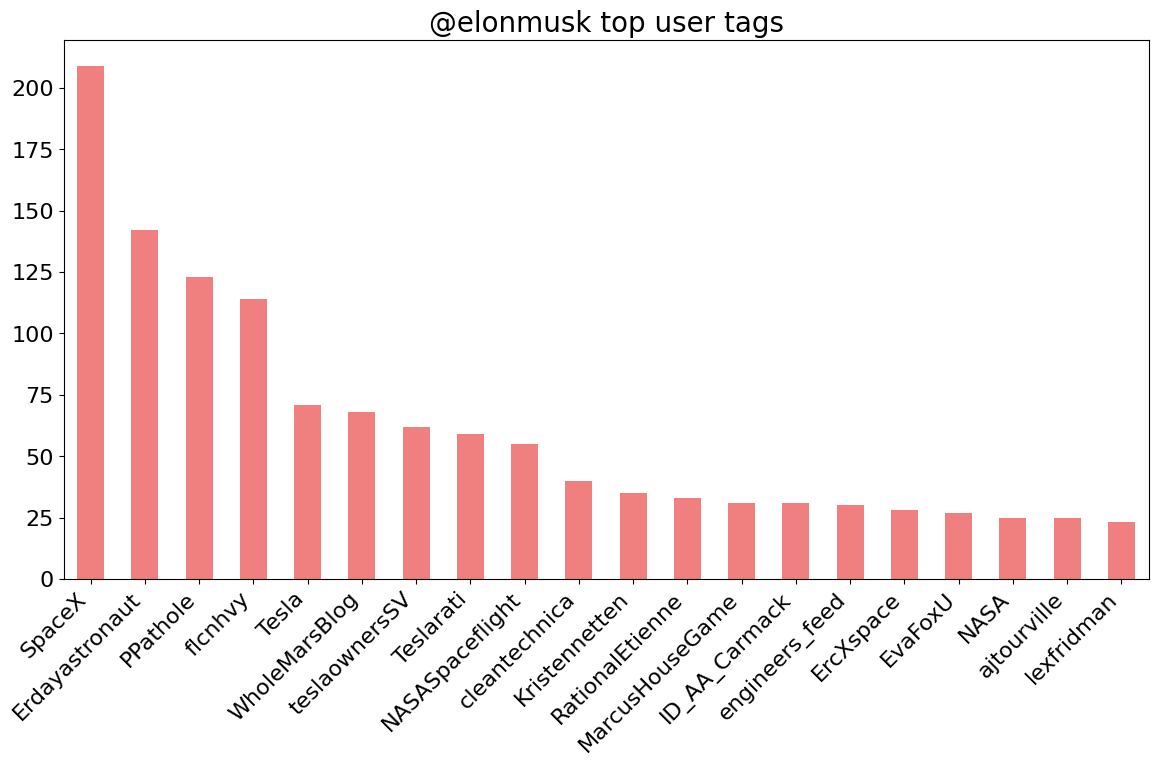

In [55]:
import itertools

c = list(
itertools.chain(
    *tweets.Tweets.map(lambda t: [handle.replace(":", "")[1:] for handle in t.split(" ")
                            if '@' in handle.replace(":", "")]).tolist())
)

pd.Series(c).value_counts().head(20).plot.bar(
    figsize=(14, 7), fontsize=16, color='lightcoral'
)
plt.gca().set_title('@elonmusk top user tags', fontsize=20)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, ha='right', fontsize=16)
pass

**4. BasicText Preprocessing**

In [56]:
#A. For Classification
#To apply Bag of Words or TF-IDF where each Word have signifance rather than each tweet/sentence
#Collecting all the Tweets for Textual Pre-Processing
tweets=[Text.strip() for Text in tweets.Tweets] # remove both the leading and the trailing characters
tweets=[Text for Text in tweets if Text] # removes empty strings, because they are considered in Python as False
tweets[0:10]

['@kunalb11 I\x92m an alien',
 '@ID_AA_Carmack Ray tracing on Cyberpunk with HDR is next-level. Have you tried it?',
 '@joerogan @Spotify Great interview!',
 '@gtera27 Doge is underestimated',
 '@teslacn Congratulations Tesla China for amazing execution last year. Now on to the next for even more!!',
 'Happy New Year of the Ox! https://t.co/9WFKMYu2oj',
 'Frodo was the underdoge,\nAll thought he would fail,\nHimself most of all. https://t.co/zGxJFDzzrM',
 '@OwenSparks_ @flcnhvy @anonyx10 Haha thanks :)',
 '@flcnhvy @anonyx10 Indeed! Tweets definitely do not represent real-world time allocation.',
 'The most entertaining outcome is the most likely']

In [57]:
#Combining all the Tweets into Text
# Joining the list into one string/text
tweets_text=' '.join(tweets)
tweets_text[:1000]

'@kunalb11 I\x92m an alien @ID_AA_Carmack Ray tracing on Cyberpunk with HDR is next-level. Have you tried it? @joerogan @Spotify Great interview! @gtera27 Doge is underestimated @teslacn Congratulations Tesla China for amazing execution last year. Now on to the next for even more!! Happy New Year of the Ox! https://t.co/9WFKMYu2oj Frodo was the underdoge,\nAll thought he would fail,\nHimself most of all. https://t.co/zGxJFDzzrM @OwenSparks_ @flcnhvy @anonyx10 Haha thanks :) @flcnhvy @anonyx10 Indeed! Tweets definitely do not represent real-world time allocation. The most entertaining outcome is the most likely @GiveDirectly Just sent some Just agree to do Clubhouse with @kanyewest https://t.co/3rWE9uHSTS @geoffkeighley @UnrealEngine It\x92s getting real Bought some Dogecoin for lil X, so he can be a toddler hodler @JoshManMode He definitely has issues, but the sentencing seems a bit high @freewalletorg Thanks for fixing @freewalletorg Please unlock my account @AstroJordy <U+0001F923><U

In [59]:
#Using TweetTokenizer to remove all the Twitter Username Handles
# remove Twitter username handles from a given twitter text. (Removes @usernames)
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer(strip_handles=True)
tweets_tokens=tknzr.tokenize(tweets_text)
print(tweets_tokens[:100])

['I', '\x92', 'm', 'an', 'alien', 'Ray', 'tracing', 'on', 'Cyberpunk', 'with', 'HDR', 'is', 'next-level', '.', 'Have', 'you', 'tried', 'it', '?', 'Great', 'interview', '!', 'Doge', 'is', 'underestimated', 'Congratulations', 'Tesla', 'China', 'for', 'amazing', 'execution', 'last', 'year', '.', 'Now', 'on', 'to', 'the', 'next', 'for', 'even', 'more', '!', '!', 'Happy', 'New', 'Year', 'of', 'the', 'Ox', '!', 'https://t.co/9WFKMYu2oj', 'Frodo', 'was', 'the', 'underdoge', ',', 'All', 'thought', 'he', 'would', 'fail', ',', 'Himself', 'most', 'of', 'all', '.', 'https://t.co/zGxJFDzzrM', 'Haha', 'thanks', ':)', 'Indeed', '!', 'Tweets', 'definitely', 'do', 'not', 'represent', 'real-world', 'time', 'allocation', '.', 'The', 'most', 'entertaining', 'outcome', 'is', 'the', 'most', 'likely', 'Just', 'sent', 'some', 'Just', 'agree', 'to', 'do', 'Clubhouse', 'with']


In [60]:
#Joining all the Tokenized words into Text/String
# Again Joining the list into one string/text
tweets_tokens_text=' '.join(tweets_tokens)
tweets_tokens_text[:1000]

'I \x92 m an alien Ray tracing on Cyberpunk with HDR is next-level . Have you tried it ? Great interview ! Doge is underestimated Congratulations Tesla China for amazing execution last year . Now on to the next for even more ! ! Happy New Year of the Ox ! https://t.co/9WFKMYu2oj Frodo was the underdoge , All thought he would fail , Himself most of all . https://t.co/zGxJFDzzrM Haha thanks :) Indeed ! Tweets definitely do not represent real-world time allocation . The most entertaining outcome is the most likely Just sent some Just agree to do Clubhouse with https://t.co/3rWE9uHSTS It \x92 s getting real Bought some Dogecoin for lil X , so he can be a toddler hodler He definitely has issues , but the sentencing seems a bit high Thanks for fixing Please unlock my account <U+0001F923> <U+0001F923> This is true power haha https://t.co/Fc9uhQSd7O Any crypto wallet that won \x92 t give you your private keys should be avoided at all costs Your app sucks RT : NASA has selected Falcon Heavy to 

In [61]:
#Removing all the Punctuations fromt the Combined Text
# Remove Punctuations
no_punc_text=tweets_tokens_text.translate(str.maketrans('','',string.punctuation))
no_punc_text[:1000]

'I \x92 m an alien Ray tracing on Cyberpunk with HDR is nextlevel  Have you tried it  Great interview  Doge is underestimated Congratulations Tesla China for amazing execution last year  Now on to the next for even more   Happy New Year of the Ox  httpstco9WFKMYu2oj Frodo was the underdoge  All thought he would fail  Himself most of all  httpstcozGxJFDzzrM Haha thanks  Indeed  Tweets definitely do not represent realworld time allocation  The most entertaining outcome is the most likely Just sent some Just agree to do Clubhouse with httpstco3rWE9uHSTS It \x92 s getting real Bought some Dogecoin for lil X  so he can be a toddler hodler He definitely has issues  but the sentencing seems a bit high Thanks for fixing Please unlock my account U0001F923 U0001F923 This is true power haha httpstcoFc9uhQSd7O Any crypto wallet that won \x92 t give you your private keys should be avoided at all costs Your app sucks RT  NASA has selected Falcon Heavy to launch the first two elements of the lunar Ga

In [62]:
#Removing all the URL's from the Text
# remove https or url within text
import re
no_url_text=re.sub(r'http\S+', '', no_punc_text)
no_url_text[:1000]

'I \x92 m an alien Ray tracing on Cyberpunk with HDR is nextlevel  Have you tried it  Great interview  Doge is underestimated Congratulations Tesla China for amazing execution last year  Now on to the next for even more   Happy New Year of the Ox   Frodo was the underdoge  All thought he would fail  Himself most of all   Haha thanks  Indeed  Tweets definitely do not represent realworld time allocation  The most entertaining outcome is the most likely Just sent some Just agree to do Clubhouse with  It \x92 s getting real Bought some Dogecoin for lil X  so he can be a toddler hodler He definitely has issues  but the sentencing seems a bit high Thanks for fixing Please unlock my account U0001F923 U0001F923 This is true power haha  Any crypto wallet that won \x92 t give you your private keys should be avoided at all costs Your app sucks RT  NASA has selected Falcon Heavy to launch the first two elements of the lunar Gateway together on one mission   Yes Once we can predict cash flow reason

In [63]:
#Again Tokenizing Text into individual words for further pre-processing
import nltk.data
from nltk.tokenize import word_tokenize
text_tokens=word_tokenize(no_url_text)
print(text_tokens[:100])

['I', '\x92', 'm', 'an', 'alien', 'Ray', 'tracing', 'on', 'Cyberpunk', 'with', 'HDR', 'is', 'nextlevel', 'Have', 'you', 'tried', 'it', 'Great', 'interview', 'Doge', 'is', 'underestimated', 'Congratulations', 'Tesla', 'China', 'for', 'amazing', 'execution', 'last', 'year', 'Now', 'on', 'to', 'the', 'next', 'for', 'even', 'more', 'Happy', 'New', 'Year', 'of', 'the', 'Ox', 'Frodo', 'was', 'the', 'underdoge', 'All', 'thought', 'he', 'would', 'fail', 'Himself', 'most', 'of', 'all', 'Haha', 'thanks', 'Indeed', 'Tweets', 'definitely', 'do', 'not', 'represent', 'realworld', 'time', 'allocation', 'The', 'most', 'entertaining', 'outcome', 'is', 'the', 'most', 'likely', 'Just', 'sent', 'some', 'Just', 'agree', 'to', 'do', 'Clubhouse', 'with', 'It', '\x92', 's', 'getting', 'real', 'Bought', 'some', 'Dogecoin', 'for', 'lil', 'X', 'so', 'he', 'can', 'be']


In [64]:
# Tokens count
len(text_tokens)

17847

In [65]:
#Removing the Stopwords from the Text
# Remove Stopwords
from nltk.corpus import stopwords
my_stop_words=stopwords.words('english')

sw_list = ['\x92','rt','ye','yeah','haha','Yes','U0001F923','I','U0001F3B6','U0001F5A4']
my_stop_words.extend(sw_list)

no_stop_tokens=[word for word in text_tokens if not word in my_stop_words]
print(no_stop_tokens[:100])


['alien', 'Ray', 'tracing', 'Cyberpunk', 'HDR', 'nextlevel', 'Have', 'tried', 'Great', 'interview', 'Doge', 'underestimated', 'Congratulations', 'Tesla', 'China', 'amazing', 'execution', 'last', 'year', 'Now', 'next', 'even', 'Happy', 'New', 'Year', 'Ox', 'Frodo', 'underdoge', 'All', 'thought', 'would', 'fail', 'Himself', 'Haha', 'thanks', 'Indeed', 'Tweets', 'definitely', 'represent', 'realworld', 'time', 'allocation', 'The', 'entertaining', 'outcome', 'likely', 'Just', 'sent', 'Just', 'agree', 'Clubhouse', 'It', 'getting', 'real', 'Bought', 'Dogecoin', 'lil', 'X', 'toddler', 'hodler', 'He', 'definitely', 'issues', 'sentencing', 'seems', 'bit', 'high', 'Thanks', 'fixing', 'Please', 'unlock', 'account', 'This', 'true', 'power', 'Any', 'crypto', 'wallet', 'give', 'private', 'keys', 'avoided', 'costs', 'Your', 'app', 'sucks', 'RT', 'NASA', 'selected', 'Falcon', 'Heavy', 'launch', 'first', 'two', 'elements', 'lunar', 'Gateway', 'together', 'one', 'mission']


In [66]:
#Making all the Text into Lowercase
# Making the Text in Lowercase
lower_words=[Text.lower() for Text in no_stop_tokens]
print(lower_words[:100])

['alien', 'ray', 'tracing', 'cyberpunk', 'hdr', 'nextlevel', 'have', 'tried', 'great', 'interview', 'doge', 'underestimated', 'congratulations', 'tesla', 'china', 'amazing', 'execution', 'last', 'year', 'now', 'next', 'even', 'happy', 'new', 'year', 'ox', 'frodo', 'underdoge', 'all', 'thought', 'would', 'fail', 'himself', 'haha', 'thanks', 'indeed', 'tweets', 'definitely', 'represent', 'realworld', 'time', 'allocation', 'the', 'entertaining', 'outcome', 'likely', 'just', 'sent', 'just', 'agree', 'clubhouse', 'it', 'getting', 'real', 'bought', 'dogecoin', 'lil', 'x', 'toddler', 'hodler', 'he', 'definitely', 'issues', 'sentencing', 'seems', 'bit', 'high', 'thanks', 'fixing', 'please', 'unlock', 'account', 'this', 'true', 'power', 'any', 'crypto', 'wallet', 'give', 'private', 'keys', 'avoided', 'costs', 'your', 'app', 'sucks', 'rt', 'nasa', 'selected', 'falcon', 'heavy', 'launch', 'first', 'two', 'elements', 'lunar', 'gateway', 'together', 'one', 'mission']


In [67]:
#Stemming the Text using NLTK Library
# Stemming
from nltk.stem import PorterStemmer
ps=PorterStemmer()
stemmed_tokens=[ps.stem(word) for word in lower_words]
print(stemmed_tokens[:100])

['alien', 'ray', 'trace', 'cyberpunk', 'hdr', 'nextlevel', 'have', 'tri', 'great', 'interview', 'doge', 'underestim', 'congratul', 'tesla', 'china', 'amaz', 'execut', 'last', 'year', 'now', 'next', 'even', 'happi', 'new', 'year', 'ox', 'frodo', 'underdog', 'all', 'thought', 'would', 'fail', 'himself', 'haha', 'thank', 'inde', 'tweet', 'definit', 'repres', 'realworld', 'time', 'alloc', 'the', 'entertain', 'outcom', 'like', 'just', 'sent', 'just', 'agre', 'clubhous', 'it', 'get', 'real', 'bought', 'dogecoin', 'lil', 'x', 'toddler', 'hodler', 'he', 'definit', 'issu', 'sentenc', 'seem', 'bit', 'high', 'thank', 'fix', 'pleas', 'unlock', 'account', 'thi', 'true', 'power', 'ani', 'crypto', 'wallet', 'give', 'privat', 'key', 'avoid', 'cost', 'your', 'app', 'suck', 'rt', 'nasa', 'select', 'falcon', 'heavi', 'launch', 'first', 'two', 'element', 'lunar', 'gateway', 'togeth', 'one', 'mission']


In [68]:
#Lemmatization of Text data using Spacy library
# Lemmatization
nlp=spacy.load('en_core_web_sm')
doc=nlp(' '.join(lower_words))
print(doc[:100])

alien ray tracing cyberpunk hdr nextlevel have tried great interview doge underestimated congratulations tesla china amazing execution last year now next even happy new year ox frodo underdoge all thought would fail himself haha thanks indeed tweets definitely represent realworld time allocation the entertaining outcome likely just sent just agree clubhouse it getting real bought dogecoin lil x toddler hodler he definitely issues sentencing seems bit high thanks fixing please unlock account this true power any crypto wallet give private keys avoided costs your app sucks rt nasa selected falcon heavy launch first two elements lunar gateway together one mission


In [69]:
lemmas=[token.lemma_ for token in doc]
print(lemmas[:100])


['alien', 'ray', 'trace', 'cyberpunk', 'hdr', 'nextlevel', 'have', 'try', 'great', 'interview', 'doge', 'underestimate', 'congratulation', 'tesla', 'china', 'amazing', 'execution', 'last', 'year', 'now', 'next', 'even', 'happy', 'new', 'year', 'ox', 'frodo', 'underdoge', 'all', 'thought', 'would', 'fail', 'himself', 'haha', 'thank', 'indeed', 'tweet', 'definitely', 'represent', 'realworld', 'time', 'allocation', 'the', 'entertaining', 'outcome', 'likely', 'just', 'send', 'just', 'agree', 'clubhouse', 'it', 'get', 'real', 'buy', 'dogecoin', 'lil', 'x', 'toddler', 'hodler', 'he', 'definitely', 'issue', 'sentencing', 'seem', 'bit', 'high', 'thank', 'fix', 'please', 'unlock', 'account', 'this', 'true', 'power', 'any', 'crypto', 'wallet', 'give', 'private', 'key', 'avoid', 'cost', 'your', 'app', 'suck', 'rt', 'nasa', 'select', 'falcon', 'heavy', 'launch', 'first', 'two', 'element', 'lunar', 'gateway', 'together', 'one', 'mission']


In [70]:
clean_tweets=' '.join(lemmas)
clean_tweets[:1000]

'alien ray trace cyberpunk hdr nextlevel have try great interview doge underestimate congratulation tesla china amazing execution last year now next even happy new year ox frodo underdoge all thought would fail himself haha thank indeed tweet definitely represent realworld time allocation the entertaining outcome likely just send just agree clubhouse it get real buy dogecoin lil x toddler hodler he definitely issue sentencing seem bit high thank fix please unlock account this true power any crypto wallet give private key avoid cost your app suck rt nasa select falcon heavy launch first two element lunar gateway together one mission once predict cash flow reasonably well starlink ipo starlink staggeringly difficult technical economic endeavor however spacex need pass deep chasm negative cash flow next year low cost per ton carbon sequester net value product make must scalable g it mean price country only difference taxis ship this intend earth may idea apply mar xprize team manage 100 m

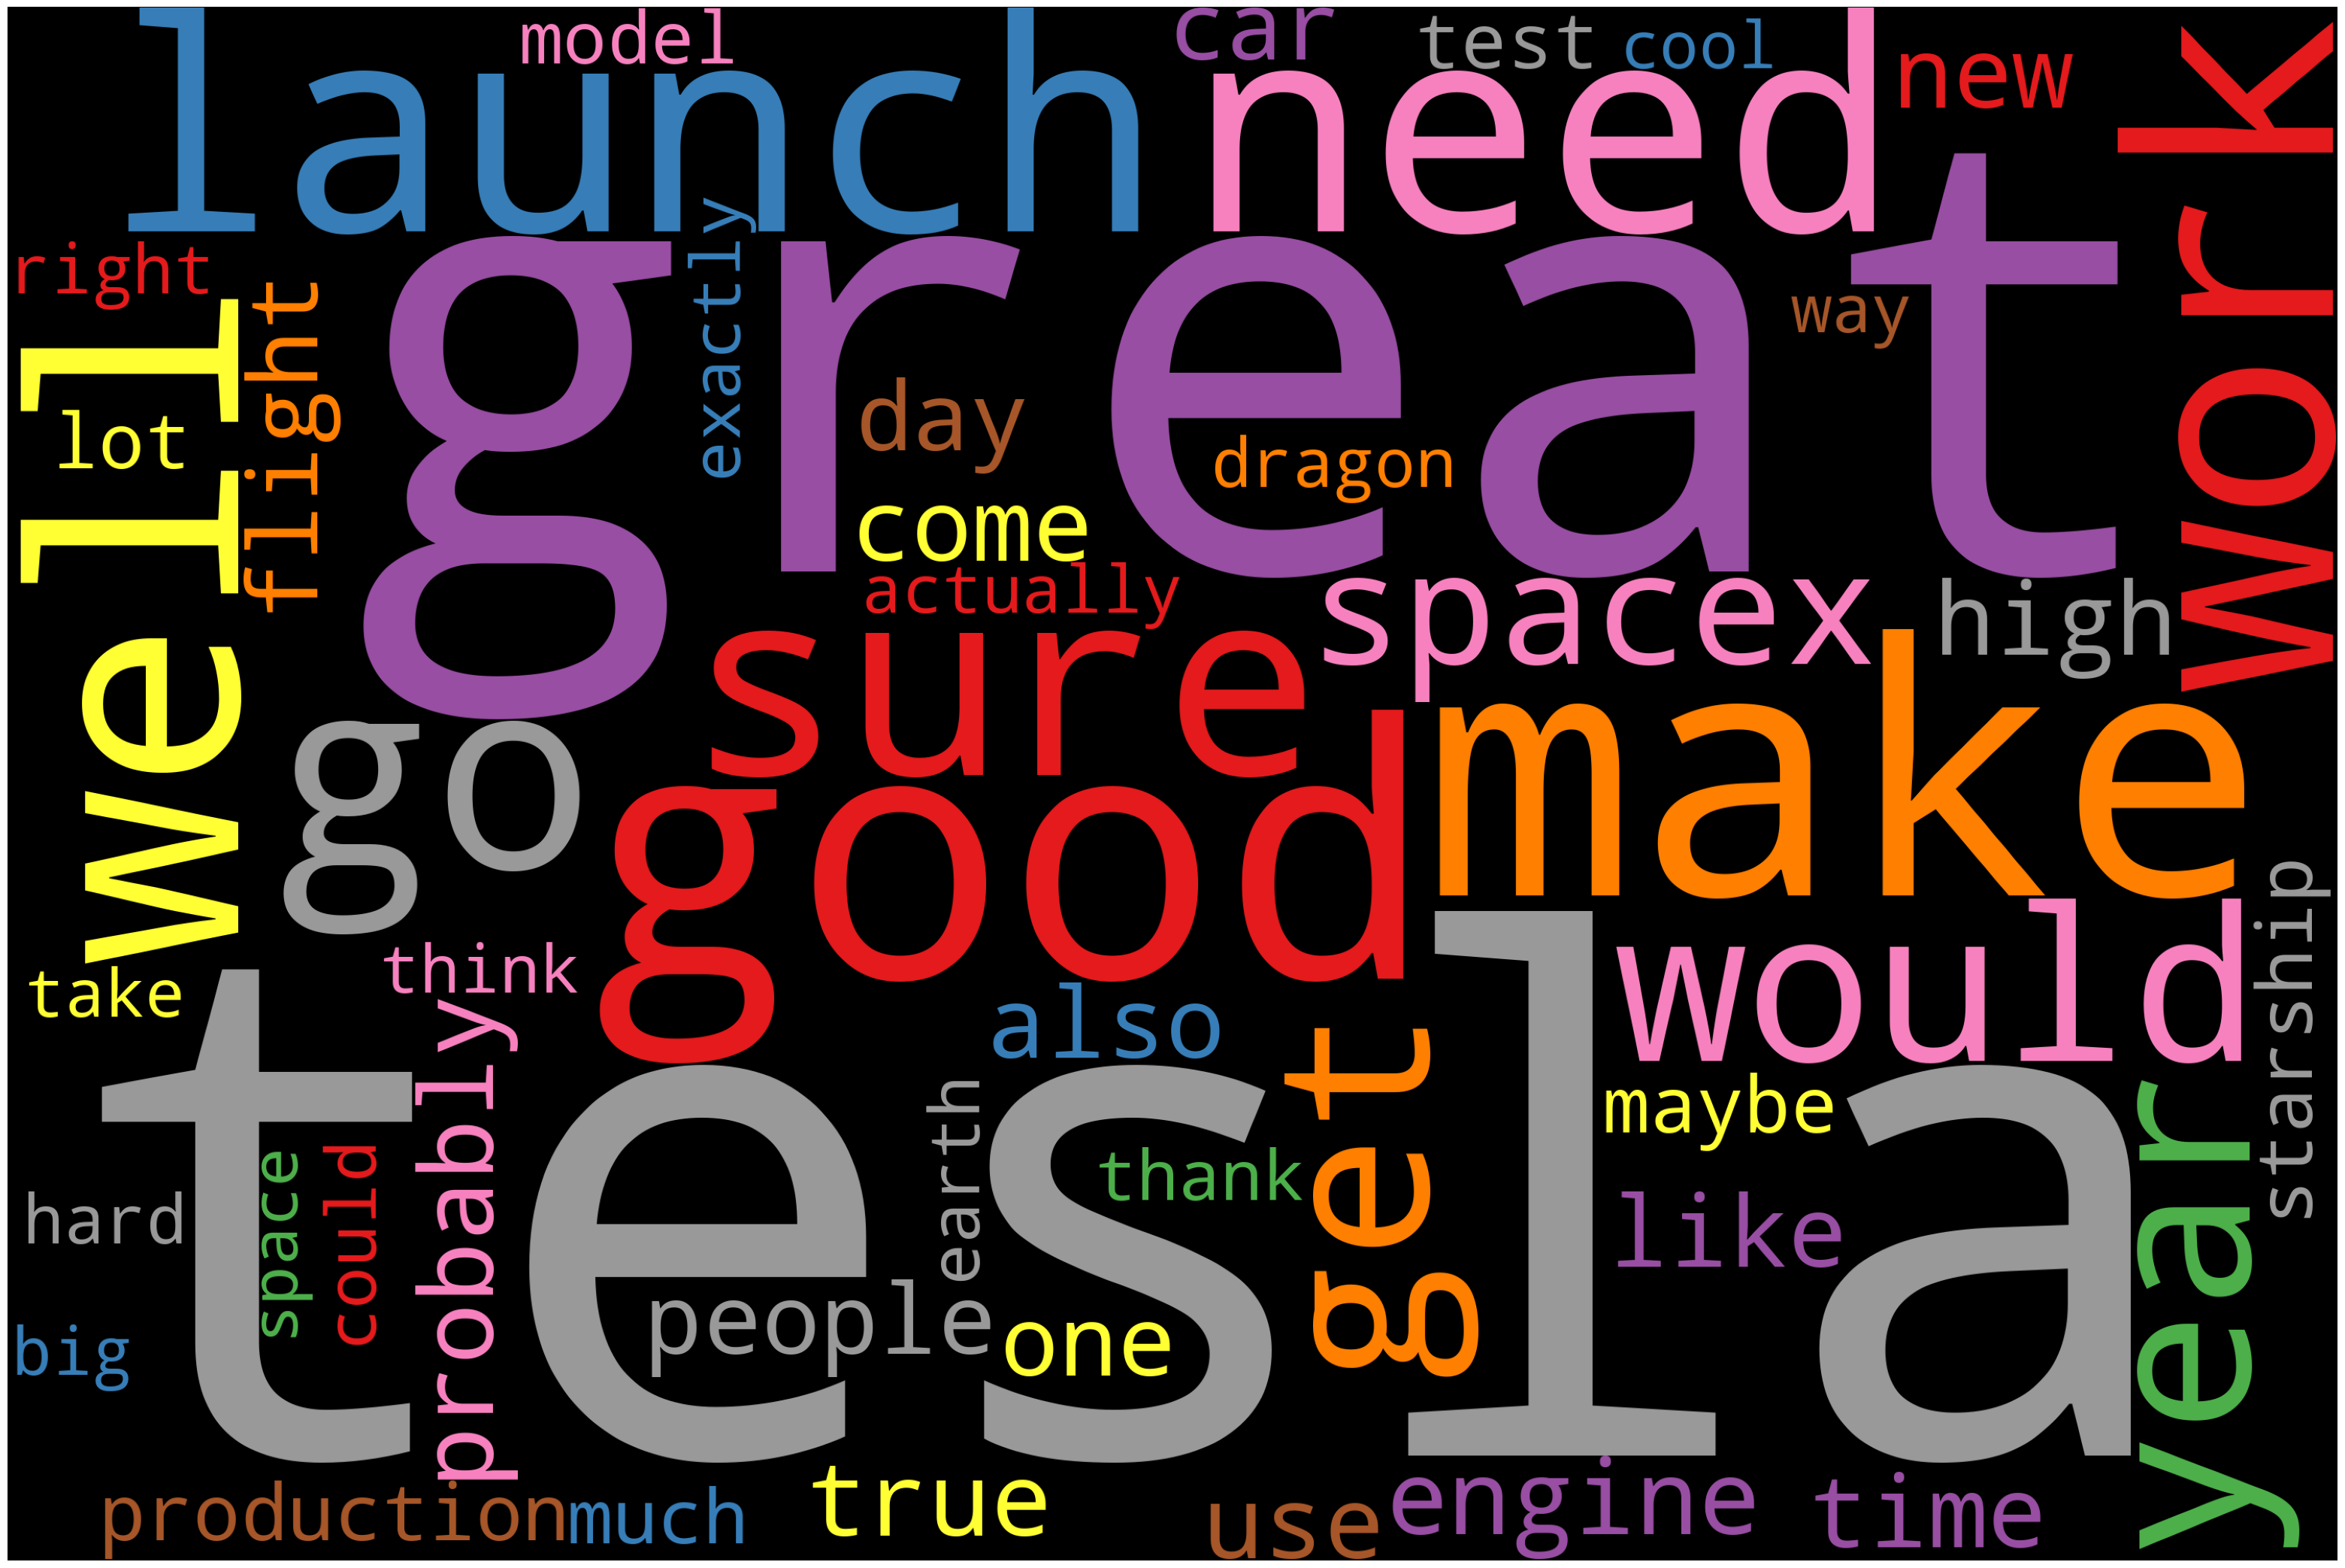

In [71]:
#Generate Word Cloud
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    plt.figure(figsize=(40,30))
    plt.imshow(wordcloud)
    plt.axis('off')

# Generate Word Cloud

#STOPWORDS.add('pron')
#STOPWORDS.add('rt')
#STOPWORDS.add('yeah')
wordcloud=WordCloud(width=3000,height=2000,background_color='black',max_words=50,
                   colormap='Set1',stopwords=my_stop_words).generate(clean_tweets)
plot_cloud(wordcloud)
